<a id="title_ID"></a>
# Satellite trail detection in ACS/WFC data using acstools.findsat_mrt

This notebook provides examples of how to find satellite trails in ACS/WFC data using <a href= 'https://acstools.readthedocs.io/en/latest/findsat_mrt.html'>acstools.findsat_mrt</a>, which is based on the method described in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. Many of the tools presented here should be applicable to any imaging data.

### Table of Contents:

[Introduction](#intro_ID) <br>
[Imports, Setup, and Data](#imports) <br>

[Example 1: Step-by-step guide to find trails in an FLC image](#example1) <br>
[Example 2: Quick run on an FLC image](#example2)<br>
[Example 3: Find trails in an FLC image using the WFC wrapper](#example3) <br>
[Example 4: Step-by-step guide to find trails in a DRC image](#example4) <br>
[Example 5: Find trails in a DRC image using the WFC wrapper](#example5)<br>
[Example 6: Create a new kernel for detection](#example6)<br>

[About this Notebook](#about_ID) 

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243162/1/1567011208101/acs_Ch46.2.jpg">diffraction spikes</a> and <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">glint</a> (see <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">Section 4.5 of the ACS DHB</a> for further discussion on these artifacts). 

A full description of the algorithm is provided in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard <a href="https://en.wikipedia.org/wiki/Radon_transform">Radon Transform</a> except that it calculates the median, rather than the sum, of data along all possible paths through an image. This modification makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive to persistent linear features, even well-below the background noise level. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence across the image. These parameters, especially the maximum allowed trail width, are tuned for ACS/WFC data binned 2x2 and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created. The routine provides numerous ways of visualizing the results, as will be demonstrated below.

The following examples illustrate how to use `acstools.findsat_mrt` to identify and mask satellite trails. Some examples outline the detailed steps whereby an image is preprocessed before it is analyzed. Other examples demonstrate how to automate many of these steps.

<a id="imports"></a>
## Imports, setup, and data

Set your working directory and import the needed packages with the following

In [1]:
#check your own working directory
import os
print('Current working directory is {}'.format(os.getcwd()))

#update as needed with
#os.chdir('/Users/dstark/acs_work/satellite_trails/findsat_mrt/')

Current working directory is /Users/dstark/acs_work/acs-notebook/acs_findsat_mrt


In [2]:
#import modules and setup
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.nddata import bitmask, block_reduce, block_replicate
from acstools.findsat_mrt import TrailFinder, WfcWrapper

#These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

Download the example data needed. Examples 1-3 use  <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">jc8m32j5q_flc.fits</a>, while examples 4-5 use <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits">hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits</a>. 

<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels, subtract a median background, and make the image a bit smaller (to speed up the calculation of the MRT).

In [3]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 4 for now (chip 1)
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks

    header = h[0].header  # primary header
    image_header = h[1].header  # image header

In [4]:
# Make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially 
# (but not fully) mask trails. By default, any masked pixels are set to NaN.
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask == True] = np.nan

In [5]:
# Subtract the background from the image. Here we just do a simple median
image = image - np.nanmedian(image)

In [6]:
# The MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
binsize = 2  # adjust this as needed
image_rebin = block_reduce(image, binsize, func=np.nansum)

We now set up `TrailFinder`. Many of the parameters in the call below are optional (and set to their current values by default) but we show them to illustrate the setup. Of note is that I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties. We have also set `plot=False` in this example, so we can demonstrate how to manually create plots. Setting `plot=True` will automatically generate plots after specific processes are finished. Be aware that not all possible keyword parameters are defined below. See the <a href="https://acstools.readthedocs.io/en/latest/api/acstools.findsat_mrt.TrailFinder.html#acstools.findsat_mrt.TrailFinder">documentation</a> for complete information.

In [7]:
# Now we can set up TrailFinder
s = TrailFinder(image=image_rebin,
                header=header,
                image_header=image_header,
                save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                        'ORIENTAT','RA_APER', 'DEC_APER', 'PA_APER'],
                processes=8,
                plot=False,
                threshold=5,
                max_width=75,  
                check_persistence=True,
                min_persistence=0.5,
                output_root='example1')

Before we actually run anything, let's plot the image we are analyzing. You should see two satellite trails in this example.

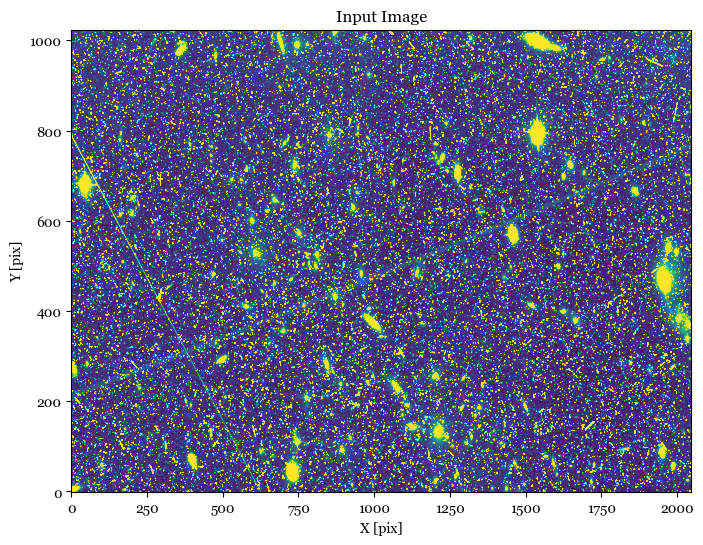

In [8]:
s.plot_image()

If you're having trouble seeing the trails, you can adjust the scale keyword (the min and max values to show given as multiples of the image standard deviation)

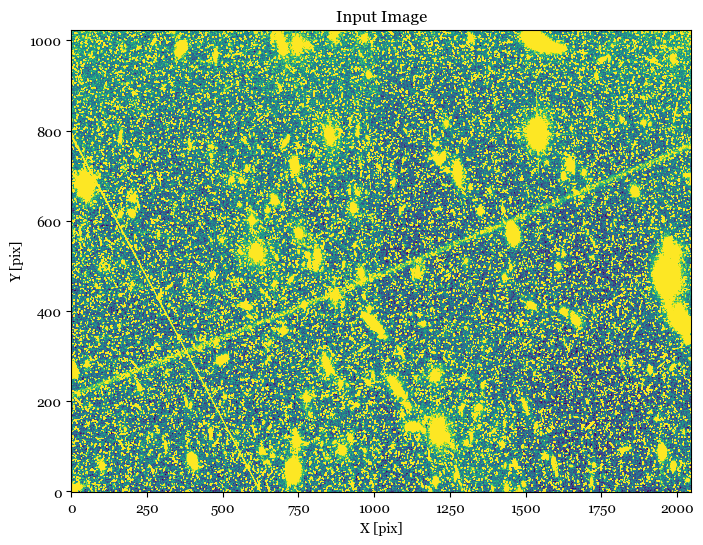

In [9]:
s.plot_image(scale=[-1, 1])

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of processes being used. This tutorial assumes you can run 8 processes together, but adjust as needed.

In [10]:
s.processes = 8  # adjust this if necessary
s.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes


Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

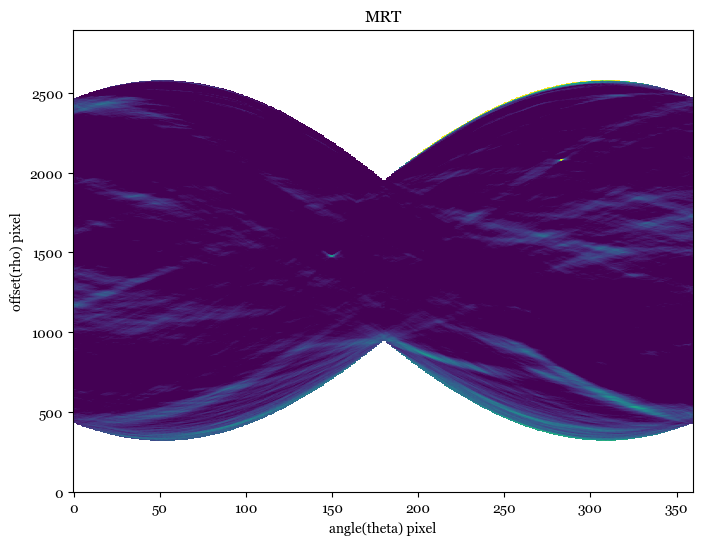

In [11]:
s.plot_mrt()

We next run the source finder on the MRT. You can create your own detection kernels, or use the defaults provided (see [Example 6](#example6) for how to create detection kernels). Depending on the settings, this can pick up a lot more than the actual trails we're interested in. There are additional steps we'll take later to filter these false detections out. The ones we found and their location on the MRT are shown below.

In [12]:
s.threshold = 5  # detection threshold
s.find_mrt_sources()

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found


<QTable length=8>
  id      xcentroid      ...                endpoints                status
int64      float64       ...               float64[2,2]              int64 
----- ------------------ ... --------------------------------------- ------
    1 149.83352094833526 ...                0.0 .. 757.2327292124636      0
    2 282.82963970572393 ...                             -0.0 .. 0.0      0
    3 1.8955105145892848 ...             738.1750240241082 .. 1023.0      0
    6   1.89141988881136 ...            1980.3150982839602 .. 1023.0      0
    7 325.40558445198184 ... 1824.6245295125004 .. 308.9119955793549      0
    8 207.51130185000048 ...   1463.3274208774326 .. 880.11521414142      0
   11  357.2180104264264 ...                735.8347094401765 .. 0.0      0
   13 1.9185304504369205 ...            1949.7033492223165 .. 1023.0      0

We filter the sources further based on a reassessment of their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data. It's possible different defaults will be better for different imaging data.

In [13]:
# Parameters that affect how the filtering works
s.threshold = 5
s.max_width = 75
s.check_persistence = True
s.min_persistence = 0.5

# now filter
s.filter_sources()

# some extra columns have been added to the source list
s.source_list

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 25.33594810771157
baseline noise: 1.1585551599206303
snr of feature = 20.86857301593415
INFO:utils_findsat_mrt:width of feature = 27.98139457625703
INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 21
INFO:utils_findsat_mrt:amplitude of feature: 26.5560608566918
baseline noise: 5.794985881719303
snr of feature = 3.582592848149085
INFO:utils_findsat_mrt:width of feature = 27.190885335740518
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.582592848149085, 27.190885335740518, 256.71290382785344
INFO:utils_findsat_mrt:Checking persistence, step 2 of 21
INFO:utils_findsat_mrt:amplitude of feature: 39.525694349629795
baseline noise: 4.212498508293069
snr of feature = 8.382957470920472
INFO:ut

INFO:utils_findsat_mrt:width of feature = 5.173546413109648
INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 10
INFO:utils_findsat_mrt:amplitude of feature: 434.35333032583424
baseline noise: 4.805897461772063
snr of feature = 89.3792338019789
INFO:utils_findsat_mrt:width of feature = 3.965034045575578
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 89.3792338019789, 3.965034045575578, 251.96442864043
INFO:utils_findsat_mrt:Checking persistence, step 2 of 10
INFO:utils_findsat_mrt:amplitude of feature: 372.5262322688963
baseline noise: 6.200344812552048
snr of feature = 59.08153474218886
INFO:utils_findsat_mrt:width of feature = 3.9962611517962046
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 59.08153474218886, 3.9962611517962046, 251.81925752230944
INFO:utils_findsat_mrt:Checking persistence, step 3 of 10
INFO:utils_findsat_mrt:amplitude of feature: 274.5557827143889


<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1 149.83352094833526 ...  20.86857301593415 0.9047619047619048
    2 282.82963970572393 ... 101.80126190570022                1.0
    3 1.8955105145892848 ...  4.807722384053967                0.0
    6   1.89141988881136 ...  6.168662324614641                0.0
    7 325.40558445198184 ...   9.16239483226501                0.0
    8 207.51130185000048 ...  8.925402967868523                0.0
   11  357.2180104264264 ... 3.6950085756423197                0.0
   13 1.9185304504369205 ...  4.115383353839861                0.0

Several columns have been added to the source list that characterize the observed streak. Also, the `status` array has values of 0, 1, and 2 now (it just had 0 before). Those with `status=2` are sources that passed all filtering stages (checks for SNR and width, then persistence). Those with `status=1` are sources that passed the first filtering stage (checks for SNR and width), but not the second (persistence check). And `status=0` are sources that did not pass the filtering steps.

The `plot_mrt` command will automatically overplot the different statuses

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

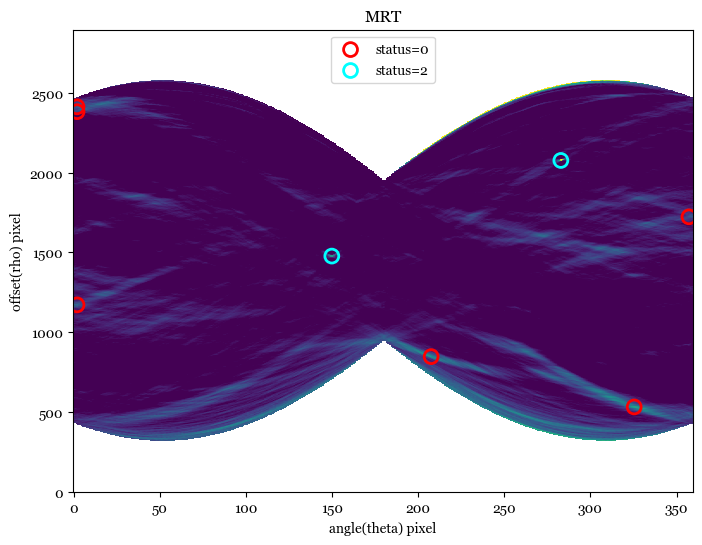

In [14]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. By default it only uses sources in the MRT with `status=2`. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the ID number. 

<AxesSubplot: title={'center': 'Segmentation Mask'}>

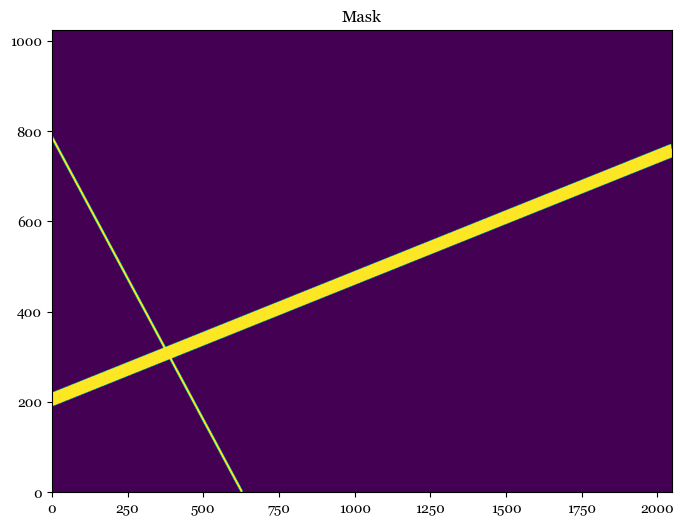

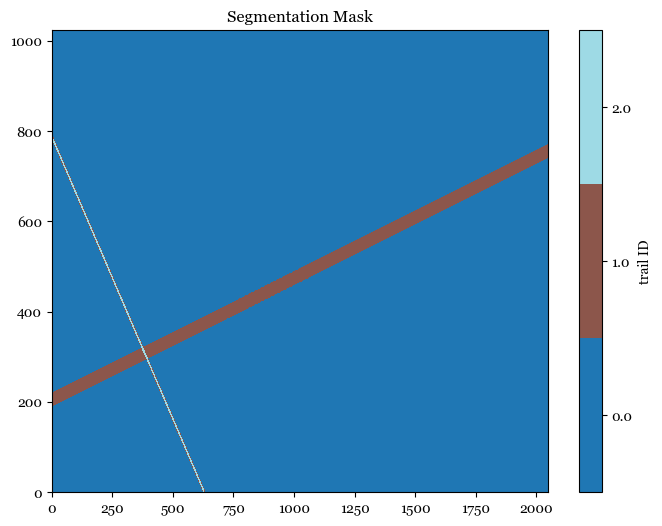

In [15]:
# make the mask
s.mask_include_status = [2]
s.make_mask()

# plot the mask and segmentation map
s.plot_mask()
s.plot_segment()

We can also overlay the mask on top of the image to make sure it makes sense.

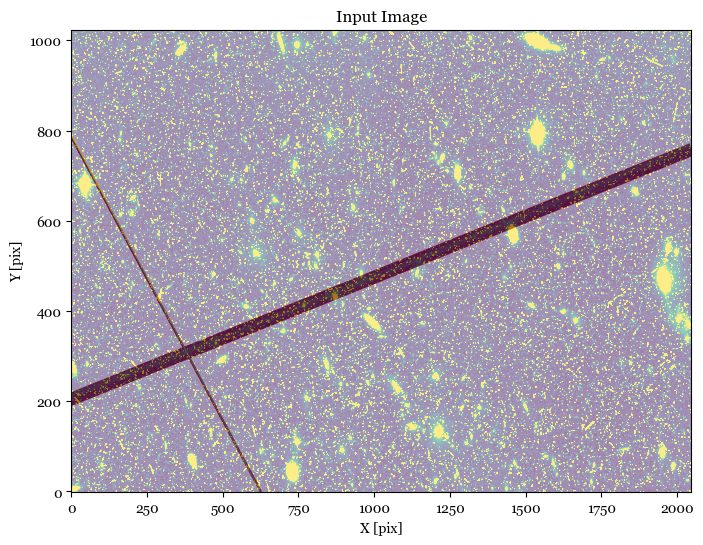

In [16]:
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [17]:
# define what to save
s.save_mask = True
s.save_mrt = True
s.save_catalog = True
s.save_diagnostic = True

s.save_output()

INFO:findsat_mrt:Wrote MRT to ./example1_mrt.fits
INFO:findsat_mrt:Wrote mask to ./example1_mask.fits
INFO:findsat_mrt:Wrote diagnostic plot to ./example1_diagnostic.png
INFO:findsat_mrt:wrote catalog ./example1_catalog.fits


Keep in mind that the mask we have created is applicable to the rebinned image. To convert it into a mask that can be applied to the original unbinned image, we need to resample it.

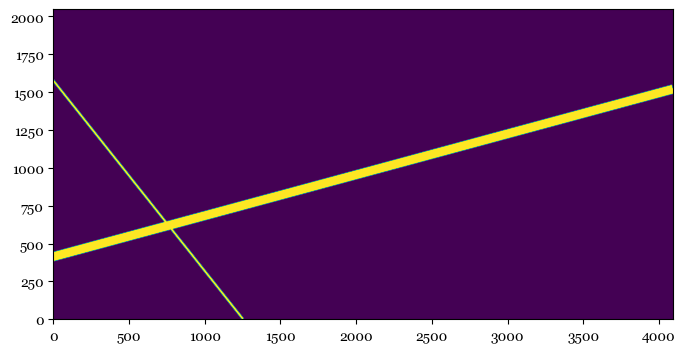

In [18]:
full_mask = block_replicate(s.mask, binsize, conserve_sum=False)
fig,ax=plt.subplots()
ax.imshow(full_mask,origin='lower')

## <a id="example2"></a>
## Example 2: Quick run of TrailFinder on an flc image

The above example thoroughly demonstrated the steps to read in an FLC file, pre-process it, and identify trails. One can run many of the steps simultaneously once a file is read in an all parameters set. 

First, we read in and preprocess the data file exactly as before.

In [19]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

# make a mask for bad pixels.
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask == True] = np.nan

# Subtract the background from the image. Here we just do a simple median
image = image - np.nanmedian(image)

# The MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin = block_reduce(image, 2, func=np.nansum)

And initialize trail finder as before

In [20]:
#Now we can set up TrailFinder
s2 = TrailFinder(image=image_rebin,
                header=header,
                image_header=image_header,
                save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                        'ORIENTAT','RA_APER', 'DEC_APER', 'PA_APER'],
                processes=8,
                plot=False,
                threshold=5,
                max_width=75,  
                check_persistence=True,
                min_persistence=0.5,
                output_root='example2')

If you're feeling ok about the setup, run all the subsequent steps together with the `run_all` command (this calculates the MRT, finds MRT sources, filters the sources, and saves the output)

In [21]:
s2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of 

INFO:utils_findsat_mrt:amplitude of feature: 27.85278073083034
baseline noise: 5.808566589332881
snr of feature = 3.7951211891037744
INFO:utils_findsat_mrt:width of feature = 25.977067901411147
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7951211891037744, 25.977067901411147, 257.13435825547896
INFO:utils_findsat_mrt:Checking persistence, step 21 of 21
INFO:utils_findsat_mrt:amplitude of feature: 30.51308144843942
baseline noise: 4.925181053152068
snr of feature = 5.195321779878801
INFO:utils_findsat_mrt:width of feature = 29.015642554091272
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.195321779878801, 29.015642554091272, 258.2306805641226
INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 19
persistance score: 0.9047619047619048
INFO:utils_findsat_mrt:amplitude of feature: 166.4366616570473
baseline noise: 1.6190137997500456
snr of feature = 101.80126190570022
INFO:utils_findsat_mrt:width of feature = 5.173546413109648
INFO:utils_findsat_mrt

If we plot the mask, it should look identical to the one in the previous example.

<AxesSubplot: title={'center': 'Mask'}>

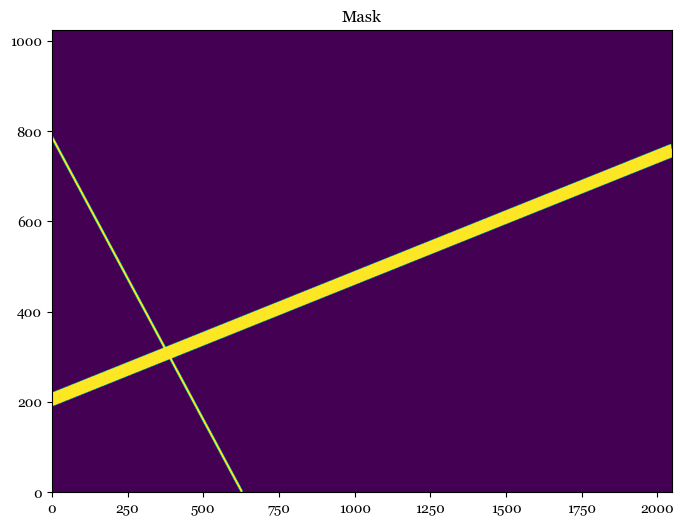

In [22]:
s2.plot_mask()

## <a id="example3"></a>
## Example 3: find trails in an FLC image using the WFC wrapper

The approaches shown in the previous two examples can be useful for any imaging data, not just ACS/WFC data. However, for ACS/WFC data, we provide a convenience wrapper script that performs even more of the steps all together, including reading the image and pre-processing it.

The `WfcWrapper` class has the same properties as the TrailFinder class, but with a few additional keywords. It also contains the additional routines that read the image, rebin, mask, and subtract the background. By default, these will be run automatically when WfcWrapper is initialized, although this can be turned off. In most cases, you probably will only need to adjust the `binsize` keyword. 

In [23]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, processes=8, output_root='example3')

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2


We can plot the image to see that it looks like the one from the last example after preprocessing.

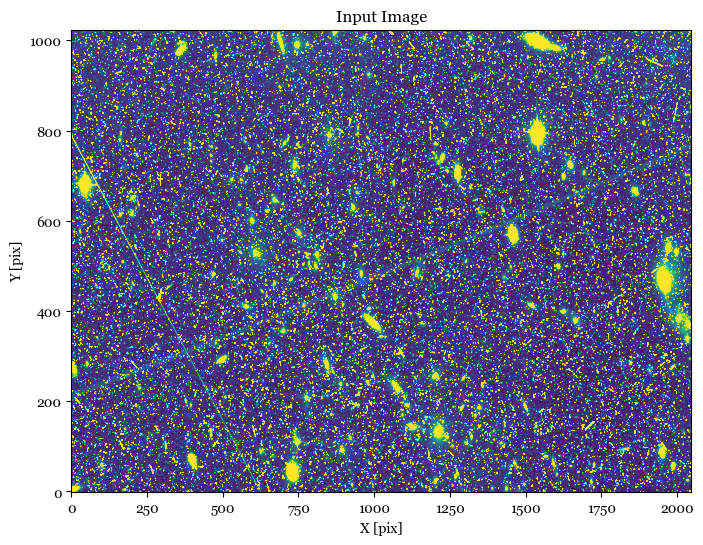

In [24]:
w.plot_image()

From here, everything is the same as the last example:

In [25]:
w.run_mrt()
w.find_mrt_sources()
w.filter_sources()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of 

INFO:utils_findsat_mrt:amplitude of feature: 27.85278073083034
baseline noise: 5.808566589332881
snr of feature = 3.7951211891037744
INFO:utils_findsat_mrt:width of feature = 25.977067901411147
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7951211891037744, 25.977067901411147, 257.13435825547896
INFO:utils_findsat_mrt:Checking persistence, step 21 of 21
INFO:utils_findsat_mrt:amplitude of feature: 30.51308144843942
baseline noise: 4.925181053152068
snr of feature = 5.195321779878801
INFO:utils_findsat_mrt:width of feature = 29.015642554091272
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.195321779878801, 29.015642554091272, 258.2306805641226
INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 19
persistance score: 0.9047619047619048
INFO:utils_findsat_mrt:amplitude of feature: 166.4366616570473
baseline noise: 1.6190137997500456
snr of feature = 101.80126190570022
INFO:utils_findsat_mrt:width of feature = 5.173546413109648
INFO:utils_findsat_mrt

<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1 149.83352094833526 ...  20.86857301593415 0.9047619047619048
    2 282.82963970572393 ... 101.80126190570022                1.0
    3 1.8955105145892848 ...  4.807722384053967                0.0
    6   1.89141988881136 ...  6.168662324614641                0.0
    7 325.40558445198184 ...   9.16239483226501                0.0
    8 207.51130185000048 ...  8.925402967868523                0.0
   11  357.2180104264264 ... 3.6950085756423197                0.0
   13 1.9185304504369205 ...  4.115383353839861                0.0

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

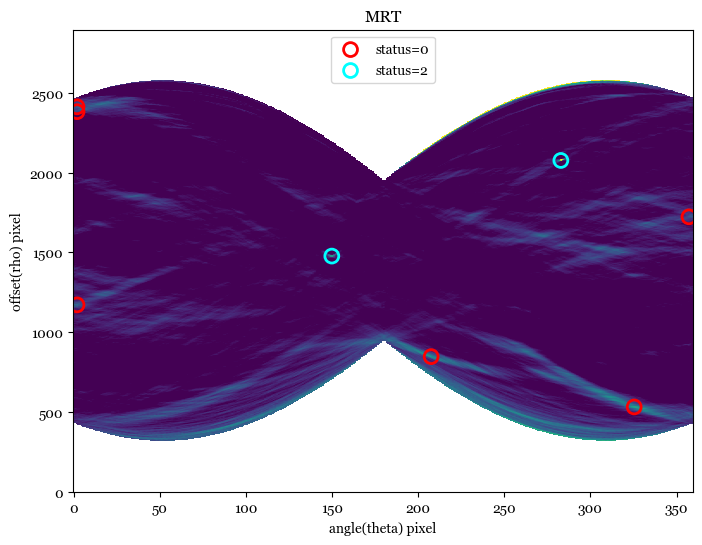

In [26]:
w.plot_mrt(show_sources=True)

<AxesSubplot: title={'center': 'Mask'}>

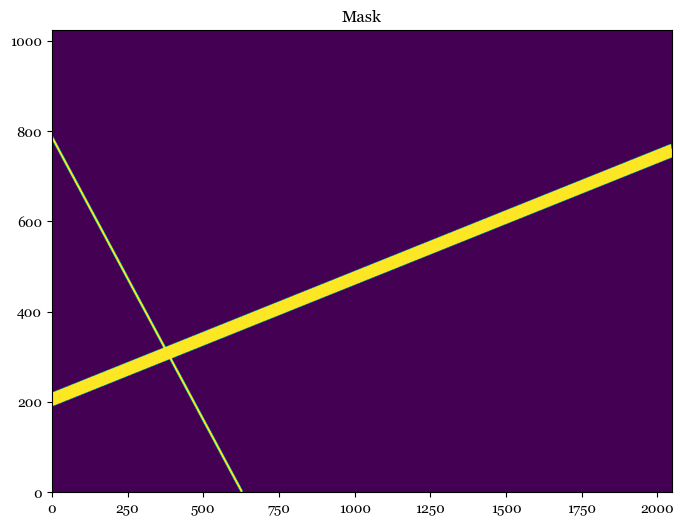

In [27]:
w.make_mask()
w.plot_mask()

If you're really feeling very confident, you can run everything in a single line by setting `execute=True`.

In [28]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, output_root='example3', processes=8,
               execute=True)

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2
INFO:findsat_mrt:Running the trailfinding pipeline
INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:f

INFO:utils_findsat_mrt:width of feature = 25.176956277518798
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.290922449413527, 25.176956277518798, 256.03589363909265
INFO:utils_findsat_mrt:Checking persistence, step 20 of 21
INFO:utils_findsat_mrt:amplitude of feature: 27.85278073083034
baseline noise: 5.808566589332881
snr of feature = 3.7951211891037744
INFO:utils_findsat_mrt:width of feature = 25.977067901411147
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7951211891037744, 25.977067901411147, 257.13435825547896
INFO:utils_findsat_mrt:Checking persistence, step 21 of 21
INFO:utils_findsat_mrt:amplitude of feature: 30.51308144843942
baseline noise: 4.925181053152068
snr of feature = 5.195321779878801
INFO:utils_findsat_mrt:width of feature = 29.015642554091272
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.195321779878801, 29.015642554091272, 258.2306805641226
INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 19
persistance score: 0.90476190

We'll plot the image and mask together to check that everything looks ok

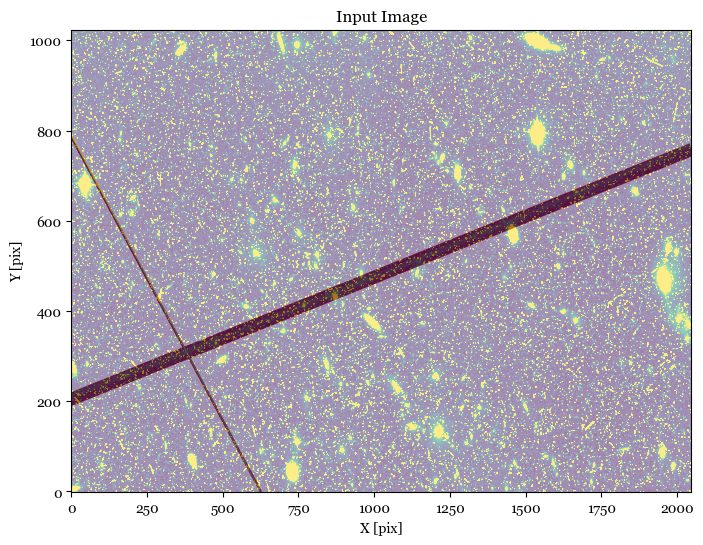

In [29]:
w.plot_image(overlay_mask=True)

<a id="example4"></a>
## Example 4: Finding trails in a DRC image

Applying `TrailFinder` to a DRC image (that shows both chips together) can boost sensitivity by increasing the number of pixels over which we search for trails. The DRC files also remove the distortion in the original FLC files (though this does not appear to create signficant curvature to most trails). 

Here, we demonstrate the steps that go into preparing a DRC image to be analyzed. The subsequent example will illustrate how to do all of this in a single line.

There are no DQ arrays for the DRC files, so we ignore the pre-processing steps that incorporated those.

In [30]:
# Read in the image files and header information
image_file = 'hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    wht = h[ext+1].data
    image = image*wht  # wht is effective exposure time, so this turns it into counts
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

In [31]:
# Flag anything with wht == 0 as bad
image[wht == 0] = np.nan

# Subtract the background from the image. Here we just do a simple median
median = np.nanmedian(image)
image = image - np.nanmedian(image)

In [32]:
# Let's rebin the images
binsize = 2
image_rebin = block_reduce(image, binsize, func=np.nansum)

Setting up `TrailFinder` is essentially the same as earlier examples at this point. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [33]:
s4 = TrailFinder(image=image_rebin, processes=8, output_root='example4')

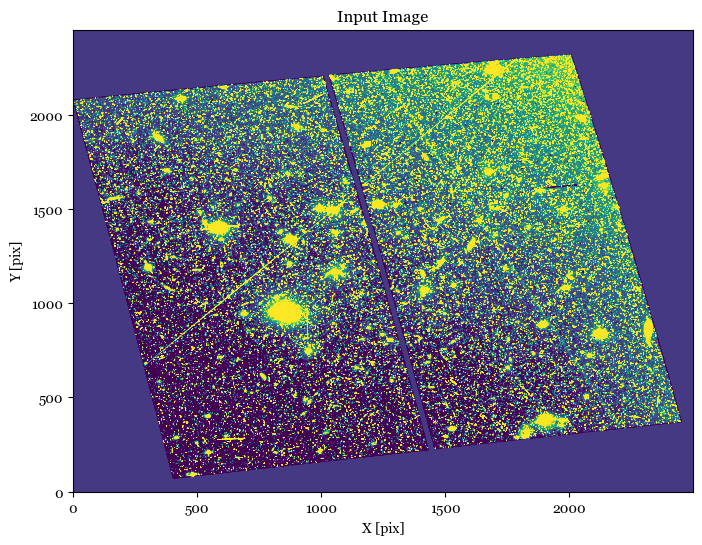

In [34]:
# We can do a quick plot of our image to make sure things look ok
s4.plot_image()

Now run the MRT calculation and plot the results

In [35]:
s4.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes


<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

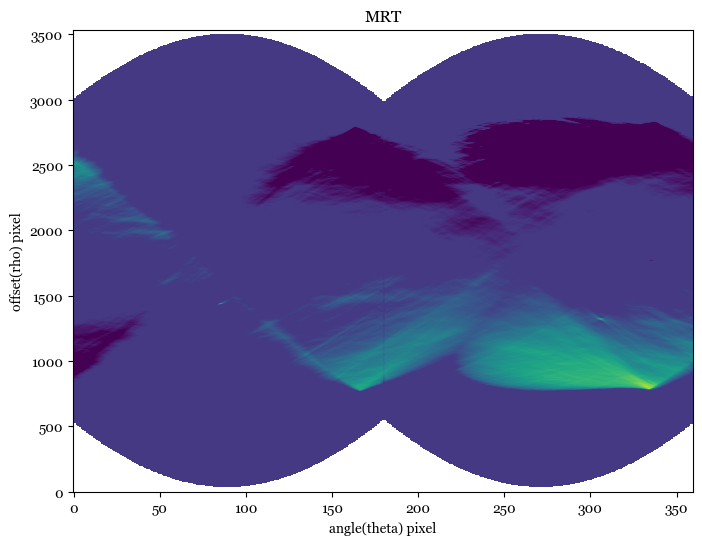

In [36]:
s4.plot_mrt(scale=[-1, 5])

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around `x,y = (90,700)` and `x,y = (300,700)`. This is a case where we may have wanted to explore some different background subtraction methods, but we'll proceed with the simpler approach here. Now we'll try to pull the sources out.

In [37]:
s4.find_mrt_sources()

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:315: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:{no} sources found using kernel: 95
INFO:findsat_mrt:52 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.mom

<QTable length=130>
  id      xcentroid      ...                endpoints                 status
int64      float64       ...               float64[2,2]               int64 
----- ------------------ ... ---------------------------------------- ------
    1 166.27442563417083 ...                0.0 .. 2366.3863566680607      0
    2  333.6313414710784 ... 1961.6853124642562 .. 159.32553035099954      0
    3  281.9621093634184 ... 1510.0944010848546 .. 1232.6285904284136      0
    4 342.32578517256405 ...                1979.2827926991956 .. 0.0      0
    5 175.63864408164147 ...                 0.0 .. 2172.557071251536      0
    6  154.4197959168269 ...                 0.0 .. 2421.179731013808      0
  ...                ... ...                                      ...    ...
  279 58.192226351234346 ...              422.0032277365064 .. 2453.0      0
  283  66.74535863207886 ...                409.29051401656 .. 2453.0      0
  287 28.212491489160875 ...              1151.127766514249 .. 2453.0      0
  289 13.398004517945902 ...             1348.7429590525944 .. 2453.0      0
  298 12.427937548578926 ...              1472.643050510338 .. 2453.0      0
  303 4.2773913518043845 ...             1636.9086151880135 .. 2453.0      0
  341 2.6631889006670164 ...             1913.4064295932017 .. 2453.0      0

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

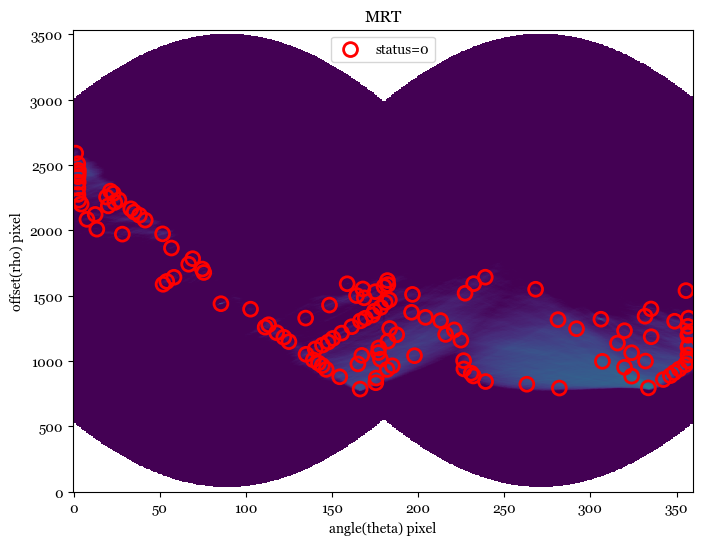

In [38]:
s4.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 16.71505458856398
baseline noise: 1.6892745228496615
snr of feature = 8.894812454974526
INFO:utils_findsat_mrt:width of feature = 144.01765759194296
INFO:utils_findsat_mrt:amplitude of feature: 26.22167421227548
baseline noise: 2.213850252148135
snr of feature = 10.844375737171998
INFO:utils_findsat_mrt:width of feature = 142.45488120662867
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 2.7796124041407935
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:amplitude of feature: 12.792426468422878
baseline noise: 1.721837850153243
snr of feature = 6.429518678128929
INFO:utils_findsat_mrt:width of feature = 137.8260629632628
INFO:utils_findsat_mrt:amplitude of feature: 12.259152320128003
baseline noise: 1.2598573182666386
snr of feature = 8.7305878549

INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3416889478091, 19.14403771252418, 251.80089756463988
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 6
INFO:utils_findsat_mrt:amplitude of feature: 12.474857031187796
baseline noise: 2.3117823068146786
snr of feature = 4.396207503801018
INFO:utils_findsat_mrt:width of feature = 74.79152333704826
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.396207503801018, 74.79152333704826, 257.5876766566893
INFO:utils_findsat_mrt:Checking persistence, step 3 of 6
INFO:utils_findsat_mrt:amplitude of feature: 13.13455354549065
baseline noise: 3.4081910711361503
snr of feature = 2.8538195985332866
INFO:utils_findsat_mrt:width of feature = 89.24840347688368
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.8538195985332866, 89.24840347688368, 257.49223530398666
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 6
INFO:utils_f

INFO:utils_findsat_mrt:width of feature = 104.94079837449908
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.796055971146201, 104.94079837449908, 235.61891059537783
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 16 of 27
INFO:utils_findsat_mrt:amplitude of feature: 29.15154980067626
baseline noise: 4.307614937925008
snr of feature = 5.767445609871215
INFO:utils_findsat_mrt:width of feature = 21.305662888444118
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.767445609871215, 21.305662888444118, 252.08513531245174
INFO:utils_findsat_mrt:Checking persistence, step 17 of 27
INFO:utils_findsat_mrt:amplitude of feature: 36.10632198933694
baseline noise: 5.331432004108124
snr of feature = 5.772349710455894
INFO:utils_findsat_mrt:width of feature = 21.132983570610236
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.772349710455894, 21.132983570610236, 252.20603827724733
INFO:utils_findsat_mrt:Checking persistence, step 18 of 27
IN

INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.638179559375885, 251.18860671654406
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 28
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 4.638179559375885
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.638179559375885, 251.18860671654406
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 28
INFO:utils_findsat_mrt:amplitude of feature: 17.141776106763004
baseline noise: 1.5470923629991473
snr of feature = 10.079995297457526
INFO:utils_findsat_mrt:width of feature = 385.5146677159353
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.079995297457526, 385.51466

INFO:utils_findsat_mrt:Chunk SNR, width, mean: 59.58721656593709, 4.047393541442091, 251.8384319377126
INFO:utils_findsat_mrt:Checking persistence, step 25 of 28
INFO:utils_findsat_mrt:amplitude of feature: 359.29470426236105
baseline noise: 7.541489838997749
snr of feature = 46.64240381315832
INFO:utils_findsat_mrt:width of feature = 3.9969533404022286
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 46.64240381315832, 3.9969533404022286, 251.94542725664564
INFO:utils_findsat_mrt:Checking persistence, step 26 of 28
INFO:utils_findsat_mrt:amplitude of feature: 491.3812418651238
baseline noise: 7.904176200422956
snr of feature = 61.167293517423076
INFO:utils_findsat_mrt:width of feature = 4.7047165252992045
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 61.167293517423076, 4.7047165252992045, 252.04895081794203
INFO:utils_findsat_mrt:Checking persistence, step 27 of 28
INFO:utils_findsat_mrt:amplitude of feature: -29.454964164171912
baseline noise: 8.125857862326354
snr of feature = -4.62

INFO:utils_findsat_mrt:width of feature = 15.64256996155757
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.111360170940383, 15.64256996155757, 249.61709885613163
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 15 of 24
INFO:utils_findsat_mrt:amplitude of feature: 32.09917682181103
baseline noise: 7.1971961338321915
snr of feature = 3.459955825147094
INFO:utils_findsat_mrt:width of feature = 108.37211919833157
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.459955825147094, 108.37211919833157, 267.99158649072456
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 16 of 24
INFO:utils_findsat_mrt:amplitude of feature: 3.5611192936127587
baseline noise: 5.191980437076858
snr of feature = -0.31411157326746253
INFO:utils_findsat_mrt:width of feature = 29.394142429272534
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.31411157326746253, 29.394142429272534, 250.7027012567

INFO:utils_findsat_mrt:Checking persistence, step 9 of 27
INFO:utils_findsat_mrt:amplitude of feature: 8.320388476801163
baseline noise: 5.784886420979105
snr of feature = 0.438297638243504
INFO:utils_findsat_mrt:width of feature = 9.768535369799906
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.438297638243504, 9.768535369799906, 253.81200853845684
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.7571360021987523
baseline noise: 10.238439575279989
snr of feature = -0.9260496683472347
INFO:utils_findsat_mrt:width of feature = 2.7638104693538708
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.9260496683472347, 2.7638104693538708, 258.2971995378531
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 11 of 27
INFO:utils_findsat_mrt:amplitude of feature: 527.6860510216034
baseline noise: 11.419850353574445
snr of fe

INFO:utils_findsat_mrt:width of feature = 1.201251274011895
INFO:utils_findsat_mrt:breaking into 31.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 31
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 1.201251274011895
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.201251274011895, 248.07269583504316
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 31
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of featur

INFO:utils_findsat_mrt:width of feature = 0.6407317286881948
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1923928091395013, 0.6407317286881948, 248.05147105392172
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 22 of 31
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.916916808814348
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.56094452362805
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 23 of 31
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 6.971583805667266
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 248.60252418727237
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 24 of 31
INFO:utils_findsat_mrt:amp

INFO:utils_findsat_mrt:amplitude of feature: -1.6482040032615402
baseline noise: 4.73356133101105
snr of feature = -1.3481953413096472
INFO:utils_findsat_mrt:width of feature = 1.4973342715675813
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.3481953413096472, 1.4973342715675813, 250.6122737824938
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 30
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.0613015954124965
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.22184799769394203
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.22184799769394203, 250.6122737824938
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 11 of 30
INFO:utils_findsat_mrt:amplitude of feature: -12.170374077777886
baseline noise: 12.082529092686569
snr of feature = -2.007270413703741
INFO:utils_findsat_mrt:width of feature = 1.656174274440957
INFO:uti

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 30 of 30
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 2.377358538015983
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 2.377358538015983, 250.6122737824938
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Number of sections analyzed: 30
Number of sections that passed: 0
persistance score: 0.0
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 7.872474670410156
baseline noise: 0.0
snr of feature = inf
INFO:utils_findsat_mrt:width of featu

INFO:utils_findsat_mrt:width of feature = 44.74057616964083
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.3785864427918864, 44.74057616964083, 243.3338124047106
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 19 of 27
INFO:utils_findsat_mrt:amplitude of feature: 51.256392784222434
baseline noise: 5.893261967020852
snr of feature = 7.697457040100568
INFO:utils_findsat_mrt:width of feature = 88.70743315620624
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.697457040100568, 88.70743315620624, 279.1999835953985
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 20 of 27
INFO:utils_findsat_mrt:amplitude of feature: 24.26854413123402
baseline noise: 5.218640682471479
snr of feature = 3.6503573646577943
INFO:utils_findsat_mrt:width of feature = 36.68983269091876
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.6503573646577943, 36.68983269091876, 227.16634542803516
INFO:

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 9 of 25
INFO:utils_findsat_mrt:amplitude of feature: 18.525130528101442
baseline noise: 3.991404536735445
snr of feature = 3.641256068534982
INFO:utils_findsat_mrt:width of feature = 70.92461418519065
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.641256068534982, 70.92461418519065, 253.9907703309023
INFO:utils_findsat_mrt:Checking persistence, step 10 of 25
INFO:utils_findsat_mrt:amplitude of feature: 3.4491890097787543
baseline noise: 4.440192177836821
snr of feature = -0.22318925135822956
INFO:utils_findsat_mrt:width of feature = 25.765143545937917
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.22318925135822956, 25.765143545937917, 253.3243251002229
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 11 of 25
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero e

INFO:utils_findsat_mrt:width of feature = 36.08720592898018
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.5600788177825553, 36.08720592898018, 248.78920163461345
INFO:utils_findsat_mrt:Checking persistence, step 3 of 7
INFO:utils_findsat_mrt:amplitude of feature: 4.239294016228559
baseline noise: 2.8387215900307563
snr of feature = 0.49338139785051205
INFO:utils_findsat_mrt:width of feature = 2.577285806489556
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.49338139785051205, 2.577285806489556, 252.26310818576587
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 7
INFO:utils_findsat_mrt:amplitude of feature: 10.378512370461301
baseline noise: 2.3769436138860085
snr of feature = 3.366326702001028
INFO:utils_findsat_mrt:width of feature = 111.96893055617494
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.366326702001028, 111.96893055617494, 218.43863639297044
INFO:utils_findsat_mrt:fit failed, will not update guesses
IN

INFO:utils_findsat_mrt:width of feature = 206.369975530436
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9674934569477338, 206.369975530436, 255.84809488390945
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 6 of 28
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.257859630662634
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 245.894972356343
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 7 of 28
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.28802783396914
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 245.894972356343
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 8 of 28
INFO:utils_findsat_mrt:amplitude of fea

INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 146.39305283788477, 244.79469104035087
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 27 of 28
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 1.1108276053207078
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 1.1108276053207078, 245.90551864567158
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 28 of 28
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 17 of 25
INFO:utils_findsat_mrt:amplitude of feature: 1.2481865685442983
baseline noise: 4.9986312218316025
snr of feature = -0.7502943279566567
INFO:utils_findsat_mrt:width of feature = 1.09988647606815
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7502943279566567, 1.09988647606815, 251.00792521359023
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 18 of 25
INFO:utils_findsat_mrt:amplitude of feature: 50.89708495360584
baseline noise: 6.7183718436627355
snr of feature = 6.575806480794261
INFO:utils_findsat_mrt:width of feature = 98.4299418784613
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.575806480794261, 98.4299418784613, 249.08185011501925
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 19 of 25
INFO:utils_findsat_mrt:amplitude of feature: 18.239

INFO:utils_findsat_mrt:Checking persistence, step 9 of 25
INFO:utils_findsat_mrt:amplitude of feature: 2.294130767483974
baseline noise: 8.111377909860458
snr of feature = -0.717171263257855
INFO:utils_findsat_mrt:width of feature = 19.49710824668776
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.717171263257855, 19.49710824668776, 251.62462232665075
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 25
INFO:utils_findsat_mrt:amplitude of feature: -1.203519913706888
baseline noise: 6.187695275892733
snr of feature = -1.1945021304452084
INFO:utils_findsat_mrt:width of feature = 11.270925141349807
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.1945021304452084, 11.270925141349807, 253.95250337164583
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 11 of 25
INFO:utils_findsat_mrt:amplitude of feature: 4.714920575013437
baseline noise: 16.085893236985488
snr of 

INFO:utils_findsat_mrt:Checking persistence, step 2 of 24
INFO:utils_findsat_mrt:amplitude of feature: 7.225269257005611
baseline noise: 1.4293387379670608
snr of feature = 4.054973369910946
INFO:utils_findsat_mrt:width of feature = 131.44237073343083
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.054973369910946, 131.44237073343083, 248.66239448772313
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 24
INFO:utils_findsat_mrt:amplitude of feature: 6.95680109804773
baseline noise: 4.272984313648219
snr of feature = 0.6280895475855618
INFO:utils_findsat_mrt:width of feature = 12.85543339921685
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.6280895475855618, 12.85543339921685, 248.66239448772313
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 24
INFO:utils_findsat_mrt:amplitude of feature: 0.48845546450225186
baseline noise: 4.6743562811432815
snr of featu

INFO:utils_findsat_mrt:amplitude of feature: 6.517042214183789
baseline noise: 4.671305944771747
snr of feature = 0.3951221117250605
INFO:utils_findsat_mrt:width of feature = 34.03828842629338
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.3951221117250605, 34.03828842629338, 241.2719160301692
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 23 of 24
INFO:utils_findsat_mrt:amplitude of feature: -0.2491443967401601
baseline noise: 0.9560202466919802
snr of feature = -1.260605774409328
INFO:utils_findsat_mrt:width of feature = 52.65739177083546
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.260605774409328, 52.65739177083546, 240.77783830016503
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 24 of 24
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
I

INFO:utils_findsat_mrt:width of feature = 25.101190313430976
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.6356615791972713, 25.101190313430976, 248.11666730358246
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 17 of 29
INFO:utils_findsat_mrt:amplitude of feature: 28.15522445967693
baseline noise: 4.051120826410789
snr of feature = 5.949983884983725
INFO:utils_findsat_mrt:width of feature = 59.838312636174805
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.949983884983725, 59.838312636174805, 301.4655214662863
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 18 of 29
INFO:utils_findsat_mrt:amplitude of feature: 4.059368072825976
baseline noise: 9.501414501406328
snr of feature = -0.5727617111930925
INFO:utils_findsat_mrt:width of feature = 35.307569365604536
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5727617111930925, 35.307569365604536, 261.6173255730776

INFO:utils_findsat_mrt:amplitude of feature: 96.85986007357823
baseline noise: 4.733535268927211
snr of feature = 19.462477740348632
INFO:utils_findsat_mrt:width of feature = 66.32276496118362
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 19.462477740348632, 66.32276496118362, 254.1642638246972
INFO:utils_findsat_mrt:Checking persistence, step 7 of 27
INFO:utils_findsat_mrt:amplitude of feature: 15.188989391975301
baseline noise: 3.978733382670326
snr of feature = 2.817543909358715
INFO:utils_findsat_mrt:width of feature = 143.13607712326623
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.817543909358715, 143.13607712326623, 227.81976305951727
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 8 of 27
INFO:utils_findsat_mrt:amplitude of feature: 4.733669021644342
baseline noise: 7.292641876310267
snr of feature = -0.3508979184866602
INFO:utils_findsat_mrt:width of feature = 41.083321005684496
INFO:utils_findsat_mrt:Chunk SNR, 

INFO:utils_findsat_mrt:width of feature = 198.1409183119672
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.674396876078232, 198.1409183119672, 285.48097291625527
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 27 of 27
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 41.09134381079494
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 41.09134381079494, 244.48268941665688
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 4
persistance score: 0.14814814814814814
INFO:utils_findsat_mrt:amplitude of feature: 1.3899920016678688
baseline noise: 0.26220096136691623
snr of feature = 4.3012467

INFO:utils_findsat_mrt:width of feature = 32.483070921719104
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.6332343970572196, 32.483070921719104, 249.56733757823264
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 17 of 25
INFO:utils_findsat_mrt:amplitude of feature: 20.002472946211405
baseline noise: 6.360505063217447
snr of feature = 2.1447931803222557
INFO:utils_findsat_mrt:width of feature = 21.408596912676387
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1447931803222557, 21.408596912676387, 247.80489797871004
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 18 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 5.511736855644772
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 244.6978033342463
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_

INFO:utils_findsat_mrt:width of feature = 13.439260317452124
INFO:utils_findsat_mrt:amplitude of feature: 2.1297777651234138
baseline noise: 1.0142621892422392
snr of feature = 1.0998295980199975
INFO:utils_findsat_mrt:width of feature = 5.610978973520616
INFO:utils_findsat_mrt:amplitude of feature: 0.8043968993528079
baseline noise: 1.7969259157475561
snr of feature = -0.5523483231537883
INFO:utils_findsat_mrt:width of feature = 4.051076510605412
INFO:utils_findsat_mrt:amplitude of feature: 4.018901663363968
baseline noise: 0.867250755785704
snr of feature = 3.634071099451461
INFO:utils_findsat_mrt:width of feature = 122.37448304831045
INFO:utils_findsat_mrt:amplitude of feature: 7.900700870983644
baseline noise: 1.0767957113911997
snr of feature = 6.337232854295164
INFO:utils_findsat_mrt:width of feature = 122.75602347387047
INFO:utils_findsat_mrt:amplitude of feature: 3.5284953325552144
baseline noise: 0.6557506518984241
snr of feature = 4.380849141880502
INFO:utils_findsat_mrt:widt

INFO:utils_findsat_mrt:Checking persistence, step 16 of 27
INFO:utils_findsat_mrt:amplitude of feature: 28.720928190749074
baseline noise: 4.513574953927957
snr of feature = 5.363232799702278
INFO:utils_findsat_mrt:width of feature = 73.49359569442228
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.363232799702278, 73.49359569442228, 253.99593404049006
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 17 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 4.53004558012016
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 251.48505413811267
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 18 of 27
INFO:utils_findsat_mrt:amplitude of feature: -2.8461285839872765
baseline noise: 5.346526943254254
snr of feature = -1.532332225049058
INFO:utils_findsat_mrt:width of feature = 1.5478

INFO:utils_findsat_mrt:width of feature = 74.30344946449551
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.2134802386177292, 74.30344946449551, 251.7232752605512
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 25
INFO:utils_findsat_mrt:amplitude of feature: 8.567991766751444
baseline noise: 5.728985111499677
snr of feature = 0.4955514109389263
INFO:utils_findsat_mrt:width of feature = 75.36042081277503
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4955514109389263, 75.36042081277503, 255.1655629212629
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 25
INFO:utils_findsat_mrt:amplitude of feature: 16.28729060650751
baseline noise: 3.5711137574341154
snr of feature = 3.560843398674062
INFO:utils_findsat_mrt:width of feature = 197.72638157556798
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.560843398674062, 197.72638157556798, 276.7232752605512
INFO:ut

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 24 of 25
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 69.26404019499387
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 69.26404019499387, 251.7232752605512
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 25 of 25
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 69.26404019499387
INFO:utils_findsat_mrt:Chunk SNR, width, mean

INFO:utils_findsat_mrt:width of feature = 81.42089613140573
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 26266.258815714606, 81.42089613140573, 270.43244602051703
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 8 of 25
INFO:utils_findsat_mrt:amplitude of feature: 9.468548300224832
baseline noise: 4.011986764366501
snr of feature = 1.3600646902233564
INFO:utils_findsat_mrt:width of feature = 17.136551087853945
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3600646902233564, 17.136551087853945, 246.47896190232822
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 9 of 25
INFO:utils_findsat_mrt:amplitude of feature: 222.09977643107356
baseline noise: 10.252345636380563
snr of feature = 20.66331338293454
INFO:utils_findsat_mrt:width of feature = 486.8758609311759
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 20.66331338293454, 486.8758609311759, 245.43244602051703
INF

INFO:utils_findsat_mrt:Checking persistence, step 1 of 27
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 4.057885338219933
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 4.057885338219933, 227.40286836253316
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 11.809522370231576
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 227.42529526938353
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 27
INFO:utils_findsat_mrt:amplitude of feature: 38.24451535960504
baseline nois

INFO:utils_findsat_mrt:amplitude of feature: 7.835981127697085
baseline noise: 6.345647198944205
snr of feature = 0.23485924792680624
INFO:utils_findsat_mrt:width of feature = 27.72863304442626
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.23485924792680624, 27.72863304442626, 231.78538665251799
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 22 of 27
INFO:utils_findsat_mrt:amplitude of feature: 14.03023599450993
baseline noise: 4.504528707966512
snr of feature = 2.1146956549964195
INFO:utils_findsat_mrt:width of feature = 246.32773872170367
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.1146956549964195, 246.32773872170367, 250.42783693814727
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 23 of 27
INFO:utils_findsat_mrt:amplitude of feature: 4.743307723121163
baseline noise: 4.877716834775701
snr of feature = -0.02755574302638243
INFO:utils_findsat_mrt:width 

INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 240.25435602621047
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 12 of 29
INFO:utils_findsat_mrt:amplitude of feature: 5.368172606881811
baseline noise: 5.653506908045584
snr of feature = -0.05047031971566349
INFO:utils_findsat_mrt:width of feature = 30.83860252671934
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.05047031971566349, 30.83860252671934, 242.7690881932133
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 13 of 29
INFO:utils_findsat_mrt:amplitude of feature: 5.24691117389333
baseline noise: 5.3842029570303325
snr of feature = -0.025498998502227
INFO:utils_findsat_mrt:width of feature = 26.731258129547086
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.025498998502227, 26.731258129547086, 241.64425024402888
INFO:utils_findsat_mrt:fit failed, will 

INFO:utils_findsat_mrt:width of feature = 9.29943428315869
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 9.29943428315869, 251.18670248949945
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 25
INFO:utils_findsat_mrt:amplitude of feature: -3.301421635096467
baseline noise: 3.091509227187206
snr of feature = -2.0678996543381656
INFO:utils_findsat_mrt:width of feature = 7.1535162901204785
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.0678996543381656, 7.1535162901204785, 251.18670248949945
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 25
INFO:utils_findsat_mrt:amplitude of feature: 16.399554957775393
baseline noise: 6.173911774902098
snr of feature = 1.6562664896576766
INFO:utils_findsat_mrt:width of feature = 33.10264456979118
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.6562664896576766, 33.10264456979118, 258.29902924138196
INFO:utils_finds

INFO:utils_findsat_mrt:width of feature = 30.889215347396856
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3872413354090445, 30.889215347396856, 262.69753543083345
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 22 of 25
INFO:utils_findsat_mrt:amplitude of feature: 26.34619803099291
baseline noise: 3.970621351991218
snr of feature = 5.635283421769898
INFO:utils_findsat_mrt:width of feature = 161.256113951245
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.635283421769898, 161.256113951245, 251.18670248949945
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 23 of 25
INFO:utils_findsat_mrt:amplitude of feature: 34.14723286013891
baseline noise: 4.5380671272992466
snr of feature = 6.524620483183785
INFO:utils_findsat_mrt:width of feature = 102.32947959555338
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.524620483183785, 102.32947959555338, 267.070583289569
INFO:u

INFO:utils_findsat_mrt:amplitude of feature: 40.053972387925874
baseline noise: 6.373641731500308
snr of feature = 5.28431500784991
INFO:utils_findsat_mrt:width of feature = 86.12009117650993
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.28431500784991, 86.12009117650993, 288.0020772956009
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 16 of 24
INFO:utils_findsat_mrt:amplitude of feature: 5.937554933740394
baseline noise: 6.719695704490295
snr of feature = -0.11639526626588942
INFO:utils_findsat_mrt:width of feature = 1.0072142430354916
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.11639526626588942, 1.0072142430354916, 267.99984287931613
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 17 of 24
INFO:utils_findsat_mrt:amplitude of feature: 32.16758190056612
baseline noise: 4.962064163602073
snr of feature = 5.48270172250553
INFO:utils_findsat_mrt:width of fea

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

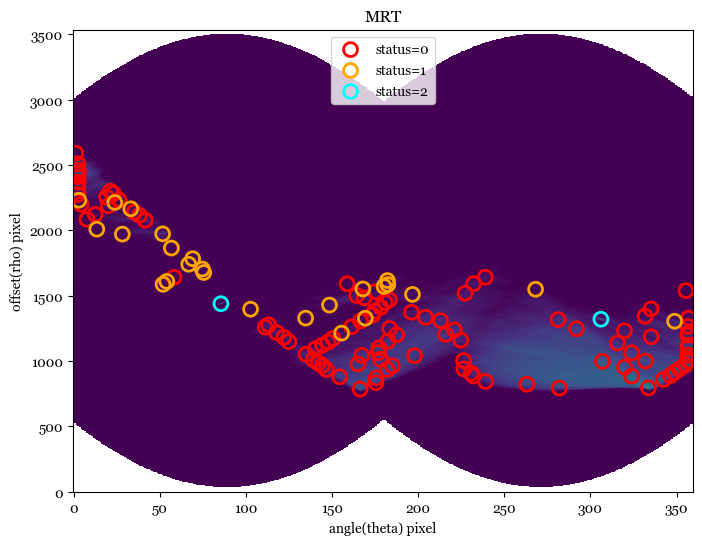

In [39]:
s4.filter_sources()
s4.plot_mrt(show_sources=True)

Let's re-plot the MRT with sources to see what made it through

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

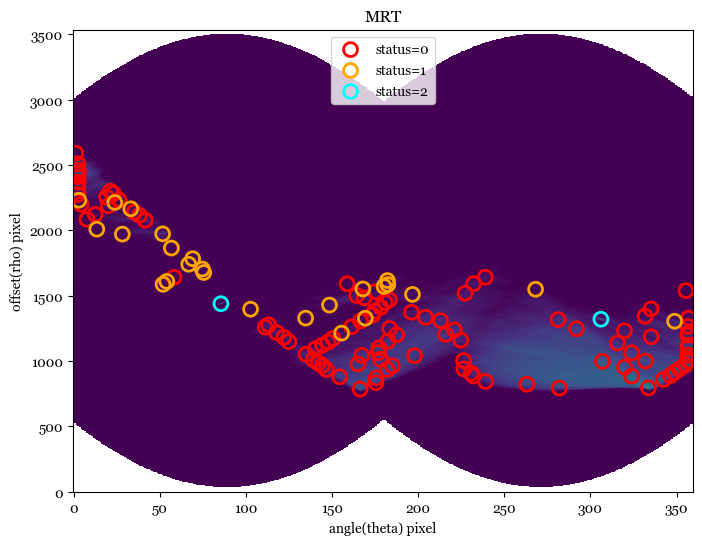

In [40]:
s4.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

<AxesSubplot: title={'center': 'Segmentation Mask'}>

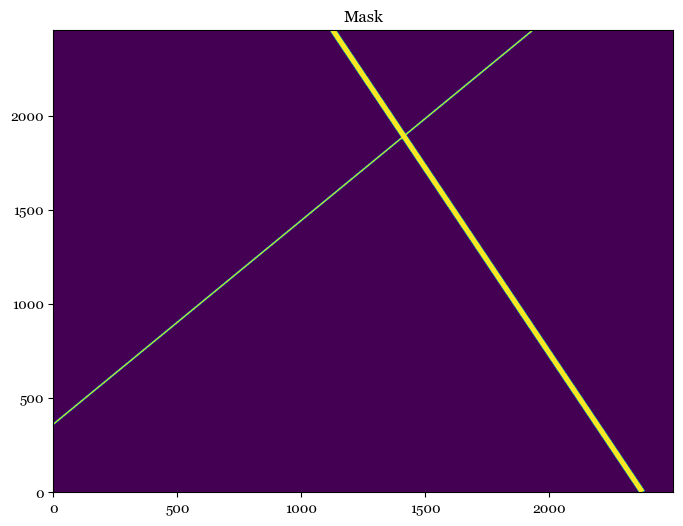

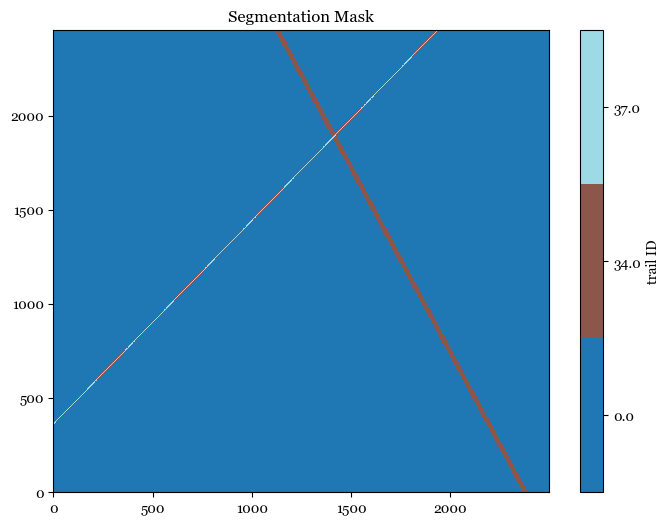

In [41]:
s4.make_mask()
s4.plot_mask()
s4.plot_segment()

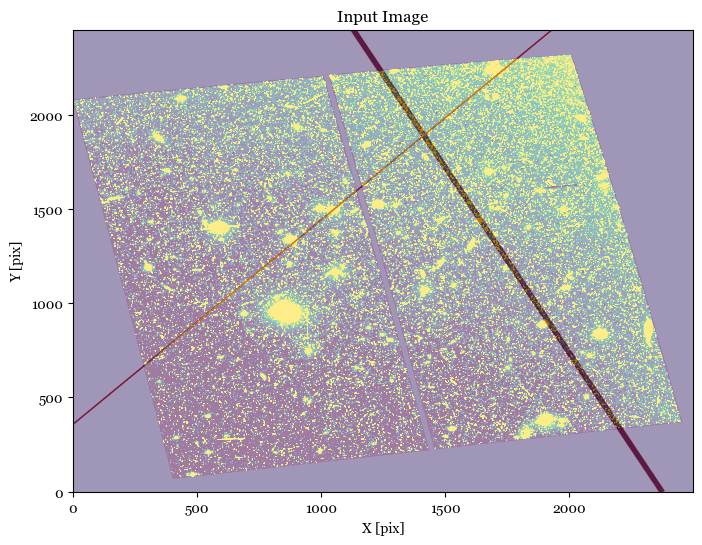

In [42]:
# Let's make a version plotting the mask on top
s4.plot_image(overlay_mask=True)

<a id="example5"></a>
## Example 5:  Finding trails in a DRC image using the WFC Wrapper

All of the setup from the last example can be streamlined using the `WfcWrapper` class.

In [43]:
from acstools.findsat_mrt import WfcWrapper
w2 = WfcWrapper('hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits', binsize=2, extension=1, processes=8,
                output_root='example5')

INFO:findsat_mrt:image type is drc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2


Run full pipeline now

In [44]:
w2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 7
INFO:findsat_mrt:7 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 12
INFO:findsat_mrt:12 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 18
INFO:findsat_mrt:18 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:19 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
/Users/dstark/python_packages/a

INFO:utils_findsat_mrt:Chunk SNR, width, mean: 162.70324130904652, 63.671561571214426, 244.89713167024462
INFO:utils_findsat_mrt:Checking persistence, step 18 of 23
INFO:utils_findsat_mrt:amplitude of feature: 0.014421222981521382
baseline noise: 0.0013109534608226913
snr of feature = 10.000560593868311
INFO:utils_findsat_mrt:width of feature = 51.29011558086302
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 10.000560593868311, 51.29011558086302, 227.67102372490737
INFO:utils_findsat_mrt:Checking persistence, step 19 of 23
INFO:utils_findsat_mrt:amplitude of feature: 0.016274441470200778
baseline noise: 0.0018005939830793558
snr of feature = 8.038373793945713
INFO:utils_findsat_mrt:width of feature = 26.155455089555403
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 8.038373793945713, 26.155455089555403, 205.96526834093484
INFO:utils_findsat_mrt:Checking persistence, step 20 of 23
INFO:utils_findsat_mrt:amplitude of feature: 0.008058163337332403
baseline noise: 0.0019554613376303507
snr

INFO:utils_findsat_mrt:width of feature = 35.05694190887681
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.742305749103531, 35.05694190887681, 253.82519621345793
INFO:utils_findsat_mrt:Checking persistence, step 14 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.02584857321428601
baseline noise: 0.0035160848960765654
snr of feature = 6.3515213592052975
INFO:utils_findsat_mrt:width of feature = 24.163424029172063
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 6.3515213592052975, 24.163424029172063, 251.40336652496464
INFO:utils_findsat_mrt:Checking persistence, step 15 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.02843266624421863
baseline noise: 0.0032843948849873646
snr of feature = 7.656896396405152
INFO:utils_findsat_mrt:width of feature = 104.59195905759168
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.656896396405152, 104.59195905759168, 235.59313277193877
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step

INFO:utils_findsat_mrt:width of feature = 4.131231659084847
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.059132132029497, 4.131231659084847, 251.21451833903797
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 28
INFO:utils_findsat_mrt:amplitude of feature: 0.20051728344395794
baseline noise: 0.0016219479535230436
snr of feature = 122.62744624968579
INFO:utils_findsat_mrt:width of feature = 4.129862793256677
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 122.62744624968579, 4.129862793256677, 251.2145159387263
INFO:utils_findsat_mrt:Checking persistence, step 6 of 28
INFO:utils_findsat_mrt:amplitude of feature: 0.25186378176128205
baseline noise: 0.0019937845657145912
snr of feature = 125.32447160659592
INFO:utils_findsat_mrt:width of feature = 4.118840908899244
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 125.32447160659592, 4.118840908899244, 251.07453626556745
INFO:utils_findsat_mrt:Checking persistence, step 7 o

INFO:utils_findsat_mrt:Checking persistence, step 27 of 28
INFO:utils_findsat_mrt:amplitude of feature: 4.070102708619983e-05
baseline noise: 9.740462965873497e-05
snr of feature = -0.5821448402524687
INFO:utils_findsat_mrt:width of feature = 64.27149137183926
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5821448402524687, 64.27149137183926, 246.88679006448677
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 28 of 28
INFO:utils_findsat_mrt:amplitude of feature: -5.266700043304372e-08
baseline noise: 1.2571985339159721e-07
snr of feature = -1.418923495472067
INFO:utils_findsat_mrt:width of feature = 4.532576679149997
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.418923495472067, 4.532576679149997, 251.4193687665588
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 20
persistance score: 0.7142857142857143
/Users/dstark/python_

INFO:utils_findsat_mrt:amplitude of feature: -0.003100507731650194
baseline noise: 0.00754619567203173
snr of feature = -1.4108703068940456
INFO:utils_findsat_mrt:width of feature = 72.92429665450373
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.4108703068940456, 72.92429665450373, 252.701516492369
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 18 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.2550473500161267
baseline noise: 0.004311210444460703
snr of feature = 58.15910468806425
INFO:utils_findsat_mrt:width of feature = 83.79325824740096
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 58.15910468806425, 83.79325824740096, 252.701516492369
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 19 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.016404524317963902
baseline noise: 0.0035602055737872975
snr of feature = 3.6077463724975285
INFO:utils_findsat_mrt

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 8 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.004783967728687773
baseline noise: 0.003332233699689485
snr of feature = 0.4356639299139098
INFO:utils_findsat_mrt:width of feature = 22.18889354163275
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.4356639299139098, 22.18889354163275, 253.39977209982618
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 9 of 27
INFO:utils_findsat_mrt:amplitude of feature: -0.0011904135671770375
baseline noise: 0.0050602735232070355
snr of feature = -1.2352468817580027
INFO:utils_findsat_mrt:width of feature = 25.67355084638703
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.2352468817580027, 25.67355084638703, 259.97516416581993
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 27
INFO:utils_findsat_mrt:amplitude of

INFO:utils_findsat_mrt:amplitude of feature: 0.0016874231776221286
baseline noise: 0.0007311932121358757
snr of feature = 1.3077664694028357
INFO:utils_findsat_mrt:width of feature = 49.885572663632274
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3077664694028357, 49.885572663632274, 269.0107062116223
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Number of sections analyzed: 27
Number of sections that passed: 2
persistance score: 0.07407407407407407
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0021363268606364727
baseline noise: 0.0
snr of feature = inf
INFO:utils_findsat_mrt:width of feature = 56.74568426220637
INFO:utils_findsat_mrt:breaking into 25.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 25
/

INFO:utils_findsat_mrt:amplitude of feature: 0.008288320717573242
baseline noise: 0.0033529932793900014
snr of feature = 1.471916889460962
INFO:utils_findsat_mrt:width of feature = 9.843317926113798
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.471916889460962, 9.843317926113798, 242.058513625248
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 19 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.021638081783902297
baseline noise: 0.0031926216360081694
snr of feature = 5.777527765851089
INFO:utils_findsat_mrt:width of feature = 61.344742944812054
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.777527765851089, 61.344742944812054, 253.48707676545305
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 20 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.03304938278477309
baseline noise: 0.004224653055917833
snr of feature = 6.822981519980201
INFO:utils_findsat_mr

INFO:utils_findsat_mrt:amplitude of feature: 0.17752784427040663
baseline noise: 0.004889229865591202
snr of feature = 35.30998115261249
INFO:utils_findsat_mrt:width of feature = 85.6071128010934
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 35.30998115261249, 85.6071128010934, 270.55876231951663
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 12 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.03132795926180898
baseline noise: 0.0007888200068688974
snr of feature = 38.714965377413044
INFO:utils_findsat_mrt:width of feature = 56.29384719850961
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 38.714965377413044, 56.29384719850961, 243.87797659001072
INFO:utils_findsat_mrt:Checking persistence, step 13 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.13225836698437324
baseline noise: 0.0016094355046359138
snr of feature = 81.17686673582655
INFO:utils_findsat_mrt:width of feature = 66.31710674912969
INFO:utils_findsat_mrt

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 27
INFO:utils_findsat_mrt:amplitude of feature: -0.005548510261511984
baseline noise: 0.004066441470805963
snr of feature = -2.3644633277882336
INFO:utils_findsat_mrt:width of feature = 1.696086427975331
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.3644633277882336, 1.696086427975331, 252.0014821911448
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 27
INFO:utils_findsat_mrt:amplitude of feature: -0.002286234139010186
baseline noise: 0.003625468123243667
snr of feature = -1.6306038451566132
INFO:utils_findsat_mrt:width of feature = 1.6961924584733765
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.6306038451566132, 1.6961924584733765, 252.00147626300122
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 6 of 27
INFO:utils_findsat_mrt:amplitude o

INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.9154140591681255, 30.794964577317955, 252.00147541557823
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 24 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.003529691216303113
baseline noise: 0.003935776118045614
snr of feature = -0.10317784588421926
INFO:utils_findsat_mrt:width of feature = 30.795038609060043
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.10317784588421926, 30.795038609060043, 252.00146784323493
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 25 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.001475310548351734
baseline noise: 0.0056397983509671595
snr of feature = -0.7384107628424808
INFO:utils_findsat_mrt:width of feature = 30.795015680122248
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.7384107628424808, 30.795015680122248, 252.00147291130435
INFO:utils_findsat_mrt:fit failed, wil

INFO:utils_findsat_mrt:width of feature = 49.86679621336381
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.7714901430878829, 49.86679621336381, 278.5659142978081
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 16 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0.0713801250740512
baseline noise: 0.004236713861037763
snr of feature = 15.847992905654236
INFO:utils_findsat_mrt:width of feature = 85.56413333655647
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 15.847992905654236, 85.56413333655647, 290.8764058830837
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 17 of 27
INFO:utils_findsat_mrt:amplitude of feature: 0
baseline noise: 0.004835022706455683
snr of feature = -1.0
INFO:utils_findsat_mrt:width of feature = 0.0
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.0, 0.0, 279.9552673917974
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_f

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 8 of 28
INFO:utils_findsat_mrt:amplitude of feature: 0.006905650532077793
baseline noise: 0.0032044410259827673
snr of feature = 1.1550250031391682
INFO:utils_findsat_mrt:width of feature = 30.873943221169185
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1550250031391682, 30.873943221169185, 268.35249877010096
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 9 of 28
INFO:utils_findsat_mrt:amplitude of feature: 0.004112817214226943
baseline noise: 0.005136683480045502
snr of feature = -0.1993243830958199
INFO:utils_findsat_mrt:width of feature = 39.516839106390336
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.1993243830958199, 39.516839106390336, 257.18571128113473
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 28
INFO:utils_findsat_mrt:amplitude 

INFO:utils_findsat_mrt:width of feature = 227.44621039866504
INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 227.44621039866504, 269.98289455253405
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 28 of 28
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0002985447645187378
baseline noise: 0.0
snr of feature = inf
INFO:utils_findsat_mrt:width of feature = 0.1946172275240201
INFO:utils_findsat_mrt:Chunk SNR, width, mean: inf, 0.1946172275240201, 241.98142531573353
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Number of sections analyzed: 28
Number of sections that passed: 5
persistance score: 0.17857142857142858
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: divide by zero encountered 

INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.3688166348920436, 31.639773147430162, 249.94750910861708
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 19 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.02040417939997974
baseline noise: 0.0031120741823023016
snr of feature = 5.556456628191555
INFO:utils_findsat_mrt:width of feature = 56.765521298513846
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.556456628191555, 56.765521298513846, 247.2594176236497
INFO:utils_findsat_mrt:Checking persistence, step 20 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.04678668590059309
baseline noise: 0.00427910442742536
snr of feature = 9.933756512397988
INFO:utils_findsat_mrt:width of feature = 91.9686535543641
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 9.933756512397988, 91.9686535543641, 254.2524185173882
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 21 of 25

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 12 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.013256475061633707
baseline noise: 0.003988633403530646
snr of feature = 2.323563165744784
INFO:utils_findsat_mrt:width of feature = 29.283232690498608
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 2.323563165744784, 29.283232690498608, 253.1952719911759
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 13 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.019117935609353136
baseline noise: 0.0033263751828559924
snr of feature = 4.747378019138138
INFO:utils_findsat_mrt:width of feature = 66.28236703178109
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.747378019138138, 66.28236703178109, 274.2377080588986
INFO:utils_findsat_mrt:Checking persistence, step 14 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.050343180891077394
baseline noise: 0.0027075938945557

INFO:utils_findsat_mrt:amplitude of feature: 0.0081144636643775
baseline noise: 0.0037225575833894583
snr of feature = 1.1798087692680175
INFO:utils_findsat_mrt:width of feature = 18.46750638059163
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.1798087692680175, 18.46750638059163, 250.05001777582984
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.008091511713236875
baseline noise: 0.0031595853637361514
snr of feature = 1.5609410038755247
INFO:utils_findsat_mrt:width of feature = 31.722197384913812
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.5609410038755247, 31.722197384913812, 256.7083920204
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 6 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.018007033283918682
baseline noise: 0.0044778599605703375
snr of feature = 3.0213480194733817
INFO:utils_findsat_m

INFO:utils_findsat_mrt:Checking persistence, step 24 of 25
INFO:utils_findsat_mrt:amplitude of feature: 0.00553952080604094
baseline noise: 0.0006860392756012399
snr of feature = 7.074640917877687
INFO:utils_findsat_mrt:width of feature = 160.932097127544
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 7.074640917877687, 160.932097127544, 255.52042203629935
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 25 of 25
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:295: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak - noise) / noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
baseline noise: 0.0
snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 56.590380928720464
INFO:utils_findsat_mrt:Chunk SNR, width, mean: nan, 56.590380928720464, 252.43516435416637
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Number of sections analyzed: 25
Nu

INFO:utils_findsat_mrt:Checking persistence, step 17 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.010942718604710584
baseline noise: 0.005901204126078152
snr of feature = 0.8543196220502447
INFO:utils_findsat_mrt:width of feature = 31.59437188697848
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 0.8543196220502447, 31.59437188697848, 229.3563633310958
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 18 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.0006119877820589328
baseline noise: 0.005608417760921389
snr of feature = -0.8908804928329035
INFO:utils_findsat_mrt:width of feature = 31.594341106208958
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.8908804928329035, 31.594341106208958, 229.35636333755463
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 19 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.014007101798555847
baseline noise: 0.003376234

INFO:utils_findsat_mrt:width of feature = 103.42710218356842
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.174278974273619, 103.42710218356842, 249.26595289107314
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 25
INFO:utils_findsat_mrt:amplitude of feature: -0.04841749403512616
baseline noise: 0.031373519058972586
snr of feature = -2.543259904766059
INFO:utils_findsat_mrt:width of feature = 7.841059247033456
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.543259904766059, 7.841059247033456, 249.26595289107314
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 11 of 25
INFO:utils_findsat_mrt:amplitude of feature: -0.004844035572611337
baseline noise: 0.006137592906319465
snr of feature = -1.7892402846763853
INFO:utils_findsat_mrt:width of feature = 8.248905800121634
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -1.7892402846763853, 8.248905800121634, 249.26

INFO:utils_findsat_mrt:amplitude of feature: -0.00032565271306736384
baseline noise: 0.0003060376129450355
snr of feature = -2.064093756102624
INFO:utils_findsat_mrt:width of feature = 29.441850816716396
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -2.064093756102624, 29.441850816716396, 233.0267576442835
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.003526903990081842
baseline noise: 0.0011986216988677221
snr of feature = 1.9424663289622834
INFO:utils_findsat_mrt:width of feature = 29.44165387756061
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 1.9424663289622834, 29.44165387756061, 233.02675905916445
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 4 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.05991036852481069
baseline noise: 0.002691892415396848
snr of feature = 21.25585546515183
INFO:utils_find

INFO:utils_findsat_mrt:width of feature = 52.64318625619842
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.5136972234299978, 52.64318625619842, 305.2460235917918
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 23 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.0022935270385283394
baseline noise: 0.0027475473864138405
snr of feature = -0.16524568425300154
INFO:utils_findsat_mrt:width of feature = 52.643178882735356
INFO:utils_findsat_mrt:Chunk SNR, width, mean: -0.16524568425300154, 52.643178882735356, 305.246023169312
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 24 of 26
INFO:utils_findsat_mrt:amplitude of feature: 0.01040784427721533
baseline noise: 0.0024200323565319727
snr of feature = 3.3007045955907346
INFO:utils_findsat_mrt:width of feature = 52.64319264984374
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.3007045955907346, 52.64319264984374, 305.

<AxesSubplot: title={'center': 'Mask'}>

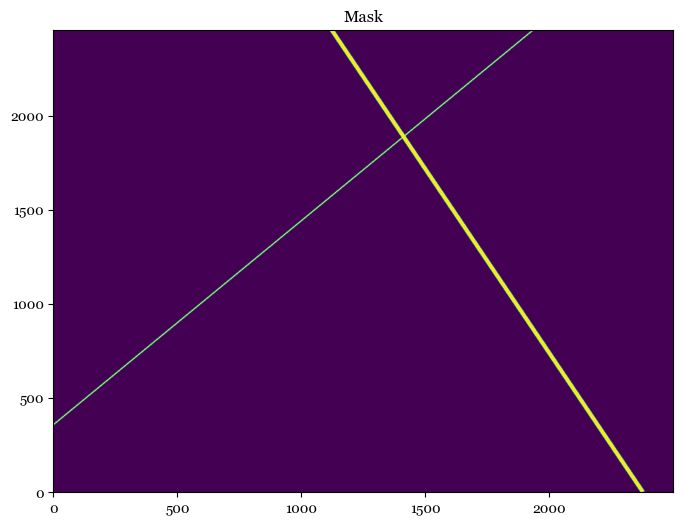

In [45]:
w2.plot_mask()

And there you go!

<a id="example6"></a>
## Example 6:  Create a new kernel for trail detection

We include a function called create_mrt_line_kernel that can be used to generate kernels for detecting trails of s specified size in the MRT. Note that kernels with widths of 1, 3, 7, and 15 pixels (convolved with a simple Gaussian HST/ACS psf model) are included already, but perhaps you want to generate a kernel with a new width, or convolved with a different PSF.

In [46]:
from acstools.utils_findsat_mrt import create_mrt_line_kernel

Let's generate a kernel for a trail that has an inherent width of 5 pixels and is convolved with a Gaussian PSF with `sigma=3`. 

In [ ]:
out = create_mrt_line_kernel(5, 3, processes=8, plot=True)

INFO:utils_findsat_mrt:calculated endpoints: [(0, 511.5), (2047, 511.5)]
INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes


<a id="about_ID"></a>
### About this Notebook
**Author:** David V. Stark, ACS Instrument Team <br>
**Updated On:** 5/11/2023